In [2]:
### clean workspace
%rm -rf /content/*

In [3]:
### prepare workspace
path2images = "/content/data/images"
path2train = "/content/data/train"
path2valid = "/content/data/valid"
path2test = "/content/data/test"

%mkdir /content/batch_1
%mkdir /content/batch_2
%mkdir /content/data/
%mkdir {path2images}
%mkdir {path2train}
%mkdir {path2valid}
%mkdir {path2test}
%mkdir /content/model_weights

In [4]:
# TODO: https://learn.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-python?tabs=managed-identity%2Croles-azure-portal%2Csign-in-azure-cli
!wget https://vibratorvials.blob.core.windows.net/data/batch_2/b2_anns_vials_down.json -q -O /content/batch_2/b2_anns_vials_down.json  # annotations
!wget https://vibratorvials.blob.core.windows.net/data/batch_1/b1_anns_vials_down.json -q -O /content/batch_1/b1_anns_vials_down.json

!wget https://vibratorvials.blob.core.windows.net/data/batch_2/b2_frames_cropped.zip -q -O /content/data/images/b2_frames_cropped.zip  # data - frames cropped
!wget https://vibratorvials.blob.core.windows.net/data/batch_1/b1_frames_cropped.zip -q -O /content/data/images/b1_frames_cropped.zip
!unzip -qq /content/data/images//b1_frames_cropped.zip -d /content/data/images
!unzip -qq /content/data/images/b2_frames_cropped.zip -d /content/data/images

!wget https://vibratorvials.blob.core.windows.net/data/model_weights/model_final_b1train.pth -O /content/model_weights/model_final_b1train.pth  # model weights

%rm -R /content/data/images/__MACOSX  # do some cleaning of files
%rm /content/data/images/b1_frames_cropped.zip
%rm /content/data/images/b2_frames_cropped.zip

--2022-12-06 14:29:20--  https://vibratorvials.blob.core.windows.net/data/model_weights/model_final_b1train.pth
Resolving vibratorvials.blob.core.windows.net (vibratorvials.blob.core.windows.net)... 52.239.137.196
Connecting to vibratorvials.blob.core.windows.net (vibratorvials.blob.core.windows.net)|52.239.137.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350967092 (335M) [application/octet-stream]
Saving to: ‘/content/model_weights/model_final_b1train.pth’

/content/model_weig 100%[===================>] 334.71M  7.16MB/s    in 1m 51s  

2022-12-06 14:31:12 (3.01 MB/s) - ‘/content/model_weights/model_final_b1train.pth’ saved [350967092/350967092]



In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
!pip install cython pyyaml==5.1
!git clone https://github.com/facebookresearch/detectron2
!pip install -e detectron2
import sys, os
sys.path.insert(0, os.path.abspath('./detectron2'))

# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# !pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
# !pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

#!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 28.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=6cb82c4b52e66b0fc5628d0fdd7e6b1b64e895937a6325acba77c1718f929bc5
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14634, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 

In [12]:
import os
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.structures import BoxMode

import sys
sys.path.insert(0, os.path.abspath('./drive/MyDrive/github-BM/vibration_vials'))

In [13]:
import json

def coco_merge(path2coco_1, path2coco_2, path2ofile, save=False, indent=None):
    """
    Merge two COCO files from different batches into one for training. 
    Args:
        path2coco_1 (str): path to COCO file 1
        path2coco_2 (str): path to COCO file 2
        path2ofile  (str): path for output file
    """
    with open(path2coco_1, "r") as f1:
        d1 = json.load(f1)
    with open(path2coco_2, "r") as f2:
        d2 = json.load(f2)
    
    odict = {k: d1[k] for k in d1 if k not in ("images", "annotations")}  # output dict
    odict["images"] = []
    odict["annotations"] = []

    for i, data in enumerate([d1, d2]):
        catid_mapper_ = {}
        for new_cat in data["categories"]:
            new_id = None
            for ocat in odict["categories"]:
                if new_cat["name"] == ocat["name"]:
                    new_id = ocat["id"]
                    break

            if new_id is not None:
                catid_mapper_[new_cat["id"]] = new_id
            else:
                new_id = max(c["id"] for c in odict["categories"]) + 1
                catid_mapper_[new_cat["id"]] = new_id
                new_cat["id"] = new_id
                odict["categories"].append(new_cat)
        
        imgid_mapper_ = {}
        for img in data["images"]:
            n_imgs = len(odict["images"])
            imgid_mapper_[img["id"]] = n_imgs
            img["id"] = n_imgs
            odict["images"].append(img)
        
        for ann in data["annotations"]:
            n_anns = len(odict["annotations"])
            ann["id"] = n_anns
            ann["image_id"] = imgid_mapper_[ann["image_id"]]
            ann["category_id"] = catid_mapper_[ann["category_id"]]

            odict["annotations"].append(ann)
    
    if save:
        with open(path2ofile, "w") as f:
            json.dump(odict, f, indent=indent)

    return odict

In [14]:
import json
import os
from sklearn.model_selection import train_test_split
# TODO: implement cross validation (k-fold)

def filter_annotations(annotations, images):
    img_ids = [x['id'] for x in images]
    return [ann for ann in annotations if ann['image_id'] in img_ids]

def save_coco(file, info, licenses, images, annotations, categories):
    coco_dict = {
        'info'       : info,
        'licenses'   : licenses,
        'images'     : images,
        'annotations': annotations,
        'categories' : categories
    }
    with open(file, 'wt', encoding='UTF-8') as coco:
        json.dump(coco_dict, coco, indent=2, sort_keys=True)
    
    return coco_dict

def coco_test_train_split(coco_anns, train_size, valid_size, verbose, p2train, p2valid, p2test):
    """
    Split COCO file of a whole dataset into train and test.
    Args:
        coco_anns    (dict): coco annotations
        train_size  (float): size of train dataset
        valid_size  (float): size of valid dataset
        verbose      (bool): show the sizes of the resulting datasets
    
    NB: the size of test dataset is inferred
    """
    info = coco_anns['info']
    lics = coco_anns['licenses']
    imgs = coco_anns['images']
    anns = coco_anns['annotations']
    cats = coco_anns['categories']

    # get the images with annotations only
    annid2imgid = {ann['id']: ann['image_id'] for ann in anns}
    imgs = [img for img in imgs if img['id'] in annid2imgid.values()]

    # TODO: include the case of having absolute sizes
    X_train, X_ = train_test_split(imgs, train_size=train_size, shuffle=True)
    X_valid, X_test = train_test_split(X_, train_size=valid_size)
    
    if verbose:
        print(f"train: {len(X_train)} ({len(X_train)/len(imgs):.2f})\n"  
              f"val: {len(X_valid)} ({len(X_valid)/len(imgs):.2f})\n"
              f"test: {len(X_test)} ({len(X_test)/len(imgs):.2f})")
    
    anns_train = filter_annotations(anns, X_train)
    anns_valid = filter_annotations(anns, X_valid)
    anns_test = filter_annotations(anns, X_test)

    train_coco_dict = save_coco(os.path.join(p2train, "coco_train.json"), info, lics, X_train, anns_train, cats)
    valid_coco_dict = save_coco(os.path.join(p2valid, "coco_valid.json"), info, lics, X_valid, anns_valid, cats)
    test_coco_dict = save_coco(os.path.join(p2test, "coco_test.json"), info, lics, X_test, anns_test, cats)

    return train_coco_dict, valid_coco_dict, test_coco_dict

In [15]:
### merge data
path2b1 = "/content/batch_1/b1_anns_vials_down.json"
path2b2 = "/content/batch_2/b2_anns_vials_down.json"
path2of = "/content/data/coco_anns.json"
coco_anns = coco_merge(path2b1, path2b2, path2of, save=True)
assert np.all([os.path.exists(f"./data/images/{img['file_name']}") for img in coco_anns["images"]])  # check all the images are registered

# split train-valid-test
train_size = 0.75
valid_size = 0.6
test_size  = 1 - valid_size

train_coco, valid_coco, test_coco = coco_test_train_split(coco_anns, 
                                                          train_size, valid_size, 
                                                          True,  # verbose 
                                                          path2train, path2valid, path2test)

train: 475 (0.75)
val: 95 (0.15)
test: 64 (0.10)


/content/data/images/video_blue_cap7_frame_1501_cropped.jpg
/content/data/images/video_blue_cap1_frame_2203_cropped.jpg
/content/data/images/video_blue_cap8_frame_4500_cropped.jpg


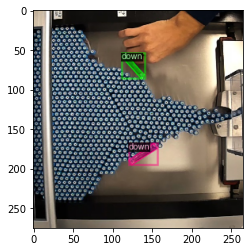

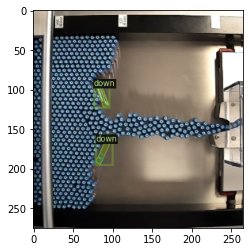

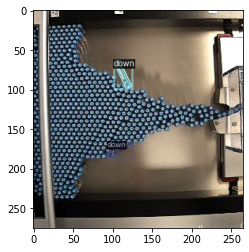

In [16]:
### pave the way for training
from detectron2.data.datasets import register_coco_instances
DatasetCatalog.clear()
register_coco_instances("train_dataset", {}, "/content/data/train/coco_train.json", "/content/data/images")
register_coco_instances("valid_dataset", {}, "/content/data/valid/coco_valid.json", "/content/data/images")

metadata = MetadataCatalog.get("train_dataset")
dataset_dicts = DatasetCatalog.get("train_dataset")

# do some visualization
import random
for d in random.sample(dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d['file_name'])
    vis = Visualizer(img[..., ::-1], metadata=metadata, scale=0.5)
    out = vis.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(out.get_image()[:,:,::-1][..., ::-1])

In [18]:
### config file for training
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("valid_dataset",)

cfg.MODEL.WEIGHTS = "model_weights/model_final_b1train.pth"
%mkdir outputs/
cfg.OUTPUT_DIR = "outputs/"

cfg.SOLVER.MAX_ITER = 7000
cfg.TEST.EVAL_PERIOD = 100

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # one class

In [19]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('valid_dataset',)
  TRAIN: ('train_dataset',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'r

In [ ]:
"""
Create a customised detectron2 Trainer
"""
import os
import copy
import torch
import cv2

from .lossevalhook import LossEvalHook

from detectron2.engine import DefaultTrainer
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from .deeplab.build_solver import build_lr_scheduler

# TODO: include augmentations and visualize them before utilise them
# TODO: lr scheduler, early stopping, k-fold

def build_train_augs():
    """ AUGMENTATION FOR TRAINING """
    transform_list = [
        # T.RandomFlip(prob=0.5, vertical=False, horizontal=True),
        T.RandomSaturation(0., 1.0),
        T.RandomRotation(5),
        T.RandomBrightness(0.5, 1.5),
    ]
    return transform_list

def bgr2gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    # image = bgr2gray(image)  # convert to grayscale
    transform_list = build_train_augs()
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
    
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [ ]:
### train!
from detectron2.engine import DefaultTrainer
# from engine.mytrainer import MyTrainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/02 13:21:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
### predict!
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
### validation
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("valid_dataset")
for d in random.sample(dataset_dicts, 18):
    img = cv2.imread(d["file_name"])
    out = predictor(img) 
    vis = Visualizer(img[:, :, ::-1],
                     metadata=metadata, 
                     scale=0.5, 
                     instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. Only available for segmentation models
    )
    out_vis = vis.draw_instance_predictions(out["instances"].to("cpu"))
    
    # cv2_imshow(out_vis.get_image()[:, :, ::-1])
    fig, axs = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)
    axs[0].imshow(img[..., ::-1])
    axs[0].axis('off')
    axs[1].imshow(out_vis.get_image()[..., ::-1])
    axs[1].axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
### test
for img_dict in X_test:
    fname = img_dict["file_name"]
    img = cv2.imread(os.path.join(path2images, fname))
    out = predictor(img) 
    vis = Visualizer(img[:, :, ::-1],
                     metadata=metadata, 
                     scale=0.5, 
                     instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. Only available for segmentation models
    )
    out_vis = vis.draw_instance_predictions(out["instances"].to("cpu"))

    # cv2_imshow(out_vis.get_image()[:, :, ::-1])
    fig, axs = plt.subplots(1, 2, figsize=(12,6), tight_layout=True)
    axs[0].imshow(img[..., ::-1])
    axs[0].axis('off')
    axs[1].imshow(out_vis.get_image()[..., ::-1])
    axs[1].axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("valid_dataset", cfg, False, output_dir="/content/output/")
val_loader = build_detection_test_loader(cfg, "valid_dataset")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[11/01 15:28:33 d2.data.datasets.coco]: Loaded 95 images in COCO format from /content/data/valid/coco_valid.json
[11/01 15:28:33 d2.data.common]: Serializing 95 elements to byte tensors and concatenating them all ...
[11/01 15:28:33 d2.data.common]: Serialized dataset takes 0.10 MiB
[11/01 15:28:33 d2.evaluation.evaluator]: Start inference on 95 images
[11/01 15:28:34 d2.evaluation.evaluator]: Inference done 11/95. 0.0846 s / img. ETA=0:00:07
[11/01 15:28:39 d2.evaluation.evaluator]: Inference done 63/95. 0.0922 s / img. ETA=0:00:03
[11/01 15:28:42 d2.evaluation.evaluator]: Total inference time: 0:00:08.639535 (0.095995 s / img per device, on 1 devices)
[11/01 15:28:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:08 (0.090578 s / img per device, on 1 devices)
[11/01 15:28:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/01 15:28:42 d2.evaluation.coco_evaluation]: Saving results to /content/output/coco_instances_results.json
[11/01 15:28:

In [ ]:
### get predictions straight from model weights
!wget https://vibratorvials.blob.core.windows.net/data/model_weights/model_final_b2train_trialF.pth -O /content/model_weights/model_final_b2train_trialF.pth

--2022-11-09 16:41:21--  https://vibratorvials.blob.core.windows.net/data/model_weights/model_final_b2train_trialF.pth
Resolving vibratorvials.blob.core.windows.net (vibratorvials.blob.core.windows.net)... 52.239.137.196
Connecting to vibratorvials.blob.core.windows.net (vibratorvials.blob.core.windows.net)|52.239.137.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 351017331 (335M) [application/octet-stream]
Saving to: ‘/content/model_weights/model_final_b2train_trialF.pth’

/content/model_weig 100%[===================>] 334.76M  56.7MB/s    in 6.5s    

2022-11-09 16:41:28 (51.1 MB/s) - ‘/content/model_weights/model_final_b2train_trialF.pth’ saved [351017331/351017331]



In [ ]:
CONFIG_FILE = "/content/configs/base_vibrationvials_semantic_config.yaml"
OPTS = ["MODEL.WEIGHTS", "model_weights/model_final_b2train_trialF.pth", "MODEL.DEVICE", "cpu"]

cfg = get_cfg()
cfg.merge_from_file(CONFIG_FILE)
cfg.merge_from_list(OPTS)
# Set score_threshold for builtin models
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.95
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95
cfg.freeze()

predictor = DefaultPredictor(cfg)

proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


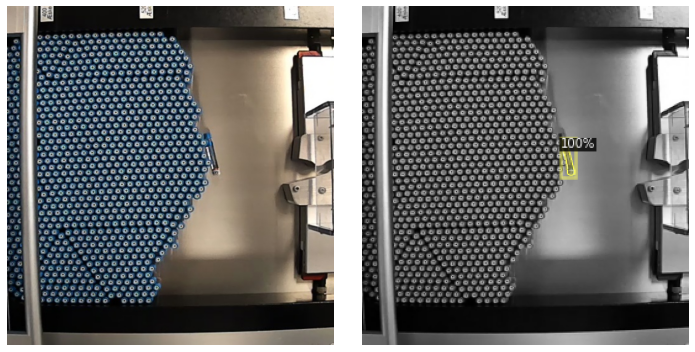

In [ ]:
import glob 
import random
from detectron2.utils.visualizer import ColorMode

fnames = glob.glob("/content/data/images/*.jpg")
metadata = MetadataCatalog.get(
    cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
)
for fname in random.sample(fnames, 1):
    img = cv2.imread(fname)
    out = predictor(img) 
    vis = Visualizer(img[:, :, ::-1],
                     metadata=metadata, 
                     scale=0.5, 
                     instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. Only available for segmentation models
    )
    out_vis = vis.draw_instance_predictions(out["instances"].to("cpu"))
    
    # cv2_imshow(out_vis.get_image()[:, :, ::-1])
    fig, axs = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)
    axs[0].imshow(img[..., ::-1])
    axs[0].axis('off')
    axs[1].imshow(out_vis.get_image()[..., ::-1])
    axs[1].axis('off')
    plt.show()

In [ ]:
out = out["instances"].to("cpu")
print(out)

Instances(num_instances=1, image_height=550, image_width=530, fields=[pred_boxes: Boxes(tensor([[321.9837, 215.2942, 346.6978, 277.6861]])), scores: tensor([0.9977]), pred_classes: tensor([0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])


In [ ]:
import torch
boxes = [x.type(torch.int).tolist() for x in out.get_fields()["pred_boxes"]]
boxes

[[321, 215, 346, 277]]

In [ ]:
all_boxes = []
all_boxes.extend(boxes)

In [ ]:
all_boxes.extend(boxes)

In [ ]:
all_boxes

[[161, 327, 204, 392],
 [162, 184, 198, 252],
 [161, 327, 204, 392],
 [162, 184, 198, 252]]

In [ ]:
gather_info = {
    "1": boxes,
    "2": boxes
}

In [ ]:
with open("boxes.json", "w") as f:
    json.dump(gather_info, f)